## Classify the concentric circles dataset using a not-so-deep neural network with non-linear activations

The following has your usual imports along with the data generation `circle` and data visualization `decision_boundary` functions predefined for you. You'll start by learning about `circle` and progress to learning about `decision_boundary` later, towards the end of the notebook.

In [1]:
import torch as pt
from torch import nn
import matplotlib.pyplot as plt
import math
%matplotlib inline
pt.manual_seed(2);

def circle(points = 100, radius_lower = 9., radius_upper = 10.):
  radius = pt.zeros(points).uniform_(radius_lower, radius_upper)
  angle = pt.zeros(points).uniform_(0, 2 * math.pi)

  x = radius * pt.sin(angle)
  y = radius * pt.cos(angle)

  return x,y

def decision_boundary(forward_fn, x_min = -15, x_max = 15, y_min = -15., y_max = 15., step = 0.25):
  import numpy as np
  xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                      np.arange(y_min, y_max, step))
  
  Xg = np.hstack( (xx.ravel()[:, None], yy.ravel()[:, None]) )


  X_test = pt.from_numpy(Xg).to(pt.float)
  y_test = forward_fn(X_test).argmax(dim = 1).detach().numpy()

  Z = -1 * y_test.reshape(xx.shape)

  fig = plt.figure()
  plt.axis("equal")
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.4);
  plt.scatter(X[:NUM, 0], X[:NUM, 1], color = 'orange');
  plt.scatter(X[NUM:, 0], X[NUM:, 1])

## Generate a tuple of tensors for the `x` and `y` coordinates of the inner circle consisting of `100` data points by using the `circle` function. 

For example, if you use

<code>
  circle(100, radius_lower = 6., radius_upper=9.)
</code>

The function is going to return a tuple with two tensors, each with a shape of `torch.Size([100])`

In [2]:
NUM = 100
xi, yi = circle(NUM, radius_lower = 6., radius_upper=9.)

## Figure out how to concatenate the `x` and `y` coordinates from the `circle` method into a single tensor

The concatenated tensor should have a of shape `torch.Size([100, 2])`

In [3]:
#inner circle
ic = pt.cat( (xi[:, None], yi[:, None]), dim = 1 )
ic.shape

torch.Size([100, 2])

## Do the same for the other circle

For example, you can use

<code>
    circle(100, radius_lower = 13., radius_upper=14.)
</code>

to generate an outer circle.

Don't forget to create a `torch.Size([100, 2])` tensor for the outer circle.

In [4]:
#outer circle
xo, yo = circle(NUM, radius_lower = 13., radius_upper=14.)
oc = pt.cat ( (xo[:, None], yo[:, None]), dim = 1)
oc.shape

torch.Size([100, 2])

## Package the values for the circles into a single `X` tensor to use for training. 

Assuming that you used 100 data points per circle, you should end up with an `X` tensor shaped `torch.Size([200, 2])`

In [5]:
X = pt.cat( (ic, oc), dim = 0 )
X.shape

torch.Size([200, 2])

Plot the circles using `scatter`.

* **hint:** recall that you can use the `axis("equal")` method to make the x and y axes equal

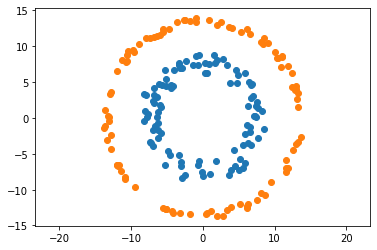

In [ ]:
plt.axis("equal")
plt.scatter(X[:NUM, 0], X[:NUM, 1])
plt.scatter(X[NUM:, 0], X[NUM:, 1]);

## Generate the `y` tensor with the classes for each of the circles. 

PyTorch loss function does not use one-hot encoding and instead relies on ordinal encoding, where each integer represents a different class. For example, one of your circles would be `0`, another circle `1`, next `2`, and so one.

In this example you only have 2 circles, so use `0` for one of the circles and `1` for another. Your `y` tensor should have a shape of `torch.Size([200])`

In [6]:
y = pt.cat( ( pt.ones(NUM).to(int), pt.zeros(NUM).to(int)), dim = 0 )
y.shape

torch.Size([200])

## Create a neural net using `nn.Sequential`. 

It should have a single hidden layer with 3 neurons. All `nn.Linear` layers should use `nn.ReLU` activation function.The output layer should have `nn.LogSoftmax` after the activation function.

Don't forget that softmax assumes one-hot encoding for the outputs!

In [14]:
model = nn.Sequential(
  nn.Linear(2, 5),
  nn.Sigmoid(),
  nn.Linear(5, 2),
  nn.Sigmoid(),
  nn.LogSoftmax(dim = 1)
)

## Implement the `forward` function. 

If your `nn.Sequential` is named `model`, then the forward pass can be as simple as returning `model(X)`.

In [15]:
def forward(X):
  return model(X)

## Complete the implementation of the cross entropy loss

If you used `nn.LogSoftmax` as the output layer of your model, you can use the negative log likelihood loss on the output of the softmax layer from `nn.functional.nll_loss`.

In [16]:
def loss(y_pred, y):
  return pt.nn.functional.nll_loss(y_pred, y)

## Implement a `metric` method that computes the prediction accuracy

The accuracy should be on a scale from `0.0` to `1.0`

In [17]:
def metric(y_pred, y):
  return (1 / len(y)) * ((y_pred.argmax(dim = 1) == y).sum())

## Create an instance of the `optim.AdamW` optimizer

* **hint:** if you used `model` as the name of your instance of `nn.Sequential`, then `model.parameters()` can be used to create the optimizer

In [18]:
optimizer = pt.optim.AdamW(model.parameters())

## Use the optimizer to discover the neural net weights for classification

You may need to perform thousands of steps of gradient descent. Don't forget to properly perform the forward and backward passes. If your instance of `AdamW` is named `optimizer`, then you can perform a gradient descent step using `optimizer.step()`. To zero out the gradients in the model, you can use `optimizer.zero_grad()`.

In [19]:
for i in range(5000):
  y_pred = forward(X)
  xe = loss(y_pred, y)
  accuracy = metric(y_pred, y)
  xe.backward()

  optimizer.step()
  optimizer.zero_grad()

print("Loss: ", xe, " Accuracy ", accuracy.data.item())

Loss:  tensor(0.3829, grad_fn=<NllLossBackward0>)  Accuracy  1.0


The `decision_boundary` function declared previously in this notebook uses a grid of test data points to draw the decision boundary for your model. The grid is like a grid on graph paper, so that for every point on the grid, you are going to use the `forward` method of your model to find out the predicted values for the points and color the grid accordingly.

The `no_grad` function disables gradient calculations when performing the `forward`.



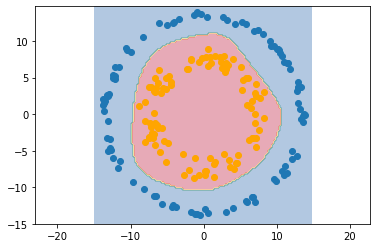

In [20]:
with pt.no_grad():
  decision_boundary(forward)

Copyright 2021 CounterFactual.AI LLC. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.